<a href="https://colab.research.google.com/github/hyunku/2020-BigContest/blob/main/dam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###댐 유입 수량 예측을 통한 최적의 수량 예측 모형 도출
댐 수위 데이터를 활용하여 댐에 유입되는 수량을 예측하고, 최적의 댐 유입 수량 예측 모형 제시

##1.데이터 전처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import torch
import torchvision
import torch.nn

In [ ]:
torch.cuda.is_available() #빠른 연산을 위해서 gpu 사용해주기. 코랩환경 기준 런타임 -> 런타임 유형 변경에서 gpu on해놓고 gpu사용하는지 확인.

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dam_raw = pd.read_excel("/content/drive/MyDrive/dacon/dam/dam_provide.xlsx",header = 1) #엑셀 파일 불러오기

In [ ]:
dam_raw

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
0,1,2006,7,10,8,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26,2018,7,7,17,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950
3047,26,2018,7,7,18,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970
3048,26,2018,7,7,19,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980
3049,26,2018,7,7,20,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990


In [ ]:
dam_raw.columns #속성들 확인

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', '유역평균강수', '강우(A지역)', '강우(B지역)', '강우(C지역)', '강우(D지역)',
       '수위(E지역)', '수위(D지역)', '유역평균강수.1', '강우(A지역).1', '강우(B지역).1', '강우(C지역).1',
       '강우(D지역).1', '수위(E지역).1', '수위(D지역).1', '유역평균강수.2', '강우(A지역).2',
       '강우(B지역).2', '강우(C지역).2', '강우(D지역).2', '수위(E지역).2', '수위(D지역).2',
       '유역평균강수.3', '강우(A지역).3', '강우(B지역).3', '강우(C지역).3', '강우(D지역).3',
       '수위(E지역).3', '수위(D지역).3', '유역평균강수.4', '강우(A지역).4', '강우(B지역).4',
       '강우(C지역).4', '강우(D지역).4', '수위(E지역).4', '수위(D지역).4', '유역평균강수.5',
       '강우(A지역).5', '강우(B지역).5', '강우(C지역).5', '강우(D지역).5', '수위(E지역).5',
       '수위(D지역).5'],
      dtype='object')

In [ ]:
dam_raw.rename(columns={'Unnamed: 0':'case_num', 'Unnamed: 1':'year', 'Unnamed: 2':'month','Unnamed: 3':'day','Unnamed: 4':'time','Unnamed: 5':'inflow'}, inplace=True) #속성 이름 변경

In [ ]:
dam_raw

,case_num,year,month,day,time,inflow,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
0,1,2006,7,10,8,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26,2018,7,7,17,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950
3047,26,2018,7,7,18,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970
3048,26,2018,7,7,19,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980
3049,26,2018,7,7,20,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990


In [ ]:
dam_raw['time']

0        8
1        9
2       10
3       11
4       12
        ..
3046    17
3047    18
3048    19
3049    20
3050    21
Name: time, Length: 3051, dtype: int64

In [ ]:
dam_raw['year'] = dam_raw['year'].astype(str)
dam_raw['month'] = dam_raw['month'].astype(str)
dam_raw['day'] = dam_raw['day'].astype(str)
dam_raw['time'] = dam_raw['time'].astype(int)

In [ ]:
dam_raw['day'].isnull().sum() #na값 확인

0

In [ ]:
dam_raw['month'].describe()

count     3051
unique       4
top          7
freq      2025
Name: month, dtype: object

In [ ]:
#7월을 07월로 바꿔주는 작업
def add_zeros(dfcolname):
  fixed_col_li = []
  for i in dfcolname:
    if len(i) == 1:
      fixed_col = '0' + i
      fixed_col_li.append(fixed_col)
    else:
      fixed_col = i
      fixed_col_li.append(fixed_col)
  return fixed_col_li

In [ ]:
dam_raw['month'] = add_zeros(dam_raw['month'])
dam_raw['day'] = add_zeros(dam_raw['day'])

In [ ]:
ymd = dam_raw['year'] + dam_raw['month'] + dam_raw['day'] #날짜 합쳐주기

In [ ]:
ymd

0       20060710
1       20060710
2       20060710
3       20060710
4       20060710
          ...   
3046    20180707
3047    20180707
3048    20180707
3049    20180707
3050    20180707
Length: 3051, dtype: object

In [ ]:
dam_raw['datetime'] = pd.to_datetime(ymd) + pd.to_timedelta(dam_raw['time'],unit='h') #시간정보 datetime으로 바꿔주기

In [ ]:
dam_raw

,case_num,year,month,day,time,inflow,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5,datetime
0,1,2006,07,10,8,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610,2006-07-10 08:00:00
1,1,2006,07,10,9,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600,2006-07-10 09:00:00
2,1,2006,07,10,10,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590,2006-07-10 10:00:00
3,1,2006,07,10,11,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585,2006-07-10 11:00:00
4,1,2006,07,10,12,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575,2006-07-10 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26,2018,07,07,17,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950,2018-07-07 17:00:00
3047,26,2018,07,07,18,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970,2018-07-07 18:00:00
3048,26,2018,07,07,19,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980,2018-07-07 19:00:00
3049,26,2018,07,07,20,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990,2018-07-07 20:00:00


In [ ]:
dam_raw.columns

Index(['case_num', 'year', 'month', 'day', 'time', 'inflow', '유역평균강수',
       '강우(A지역)', '강우(B지역)', '강우(C지역)', '강우(D지역)', '수위(E지역)', '수위(D지역)',
       '유역평균강수.1', '강우(A지역).1', '강우(B지역).1', '강우(C지역).1', '강우(D지역).1',
       '수위(E지역).1', '수위(D지역).1', '유역평균강수.2', '강우(A지역).2', '강우(B지역).2',
       '강우(C지역).2', '강우(D지역).2', '수위(E지역).2', '수위(D지역).2', '유역평균강수.3',
       '강우(A지역).3', '강우(B지역).3', '강우(C지역).3', '강우(D지역).3', '수위(E지역).3',
       '수위(D지역).3', '유역평균강수.4', '강우(A지역).4', '강우(B지역).4', '강우(C지역).4',
       '강우(D지역).4', '수위(E지역).4', '수위(D지역).4', '유역평균강수.5', '강우(A지역).5',
       '강우(B지역).5', '강우(C지역).5', '강우(D지역).5', '수위(E지역).5', '수위(D지역).5',
       'datetime'],
      dtype='object')

In [ ]:
#속성 순서들 변경(맨뒤에 생성된 datetime컬럼 앞으로 가져오기)
dam_raw = dam_raw[['case_num', 'datetime', 'year', 'month', 'day', 'time', 'inflow', '유역평균강수',
       '강우(A지역)', '강우(B지역)', '강우(C지역)', '강우(D지역)', '수위(E지역)', '수위(D지역)',
       '유역평균강수.1', '강우(A지역).1', '강우(B지역).1', '강우(C지역).1', '강우(D지역).1',
       '수위(E지역).1', '수위(D지역).1', '유역평균강수.2', '강우(A지역).2', '강우(B지역).2',
       '강우(C지역).2', '강우(D지역).2', '수위(E지역).2', '수위(D지역).2', '유역평균강수.3',
       '강우(A지역).3', '강우(B지역).3', '강우(C지역).3', '강우(D지역).3', '수위(E지역).3',
       '수위(D지역).3', '유역평균강수.4', '강우(A지역).4', '강우(B지역).4', '강우(C지역).4',
       '강우(D지역).4', '수위(E지역).4', '수위(D지역).4', '유역평균강수.5', '강우(A지역).5',
       '강우(B지역).5', '강우(C지역).5', '강우(D지역).5', '수위(E지역).5', '수위(D지역).5',
       ]]

In [ ]:
dam_raw

,case_num,datetime,year,month,day,time,inflow,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
0,1,2006-07-10 08:00:00,2006,07,10,8,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610
1,1,2006-07-10 09:00:00,2006,07,10,9,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600
2,1,2006-07-10 10:00:00,2006,07,10,10,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590
3,1,2006-07-10 11:00:00,2006,07,10,11,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585
4,1,2006-07-10 12:00:00,2006,07,10,12,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26,2018-07-07 17:00:00,2018,07,07,17,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950
3047,26,2018-07-07 18:00:00,2018,07,07,18,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970
3048,26,2018-07-07 19:00:00,2018,07,07,19,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980
3049,26,2018-07-07 20:00:00,2018,07,07,20,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990


In [ ]:
dam_df_raw = dam_raw.drop(['year','month','day','time'],axis=1)
dam_df_raw

,case_num,datetime,inflow,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
0,1,2006-07-10 08:00:00,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610
1,1,2006-07-10 09:00:00,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600
2,1,2006-07-10 10:00:00,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590
3,1,2006-07-10 11:00:00,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585
4,1,2006-07-10 12:00:00,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26,2018-07-07 17:00:00,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950
3047,26,2018-07-07 18:00:00,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970
3048,26,2018-07-07 19:00:00,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980
3049,26,2018-07-07 20:00:00,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990


In [ ]:
dam_df = dam_df_raw[dam_df_raw['case_num'] < 26]
dam_df
#26번째 사상은 사용하지 않음

,case_num,datetime,inflow,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
0,1,2006-07-10 08:00:00,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610
1,1,2006-07-10 09:00:00,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600
2,1,2006-07-10 10:00:00,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590
3,1,2006-07-10 11:00:00,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585
4,1,2006-07-10 12:00:00,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,25,2017-07-18 18:00:00,513.368437,22.7836,6,0,1,1,3.03,137.16875,8.2586,6,0,1,1,3.03,137.200000,8.2586,6,0,1,1,3.03,137.200000,4.1089,6,0,1,1,3.03,137.050000,3.2841,6,0,1,1,3.03,137.088,1.7366,6,0,1,1,3.03,137.130
2887,25,2017-07-18 19:00:00,502.846843,8.2586,2,0,1,1,3.00,137.18125,4.1089,2,0,1,1,3.00,137.200000,4.1089,2,0,1,1,3.00,137.200000,3.3854,2,0,1,1,3.00,137.067857,2.7514,2,0,1,1,3.00,137.104,1.7366,2,0,1,1,3.00,137.145
2888,25,2017-07-18 20:00:00,491.954805,4.1089,1,0,1,1,2.98,137.18750,3.3854,1,0,1,1,2.98,137.200000,3.3854,1,0,1,1,2.98,137.200000,3.2841,1,0,1,1,2.98,137.085714,2.1142,1,0,1,1,2.98,137.120,1.7366,1,0,1,1,2.98,137.155
2889,25,2017-07-18 21:00:00,481.103083,3.3854,1,0,1,1,2.96,137.19375,3.2841,1,0,1,1,2.96,137.200000,3.2841,1,0,1,1,2.96,137.208333,2.7514,1,0,1,1,2.96,137.103571,1.8734,1,0,1,1,2.96,137.136,1.7366,1,0,1,1,2.96,137.165


In [ ]:
dam_df.isnull().sum()
#결측치 확인

case_num     0
datetime     0
inflow       0
유역평균강수       0
강우(A지역)      0
강우(B지역)      0
강우(C지역)      0
강우(D지역)      0
수위(E지역)      0
수위(D지역)      0
유역평균강수.1     0
강우(A지역).1    0
강우(B지역).1    0
강우(C지역).1    0
강우(D지역).1    0
수위(E지역).1    0
수위(D지역).1    0
유역평균강수.2     0
강우(A지역).2    0
강우(B지역).2    0
강우(C지역).2    0
강우(D지역).2    0
수위(E지역).2    0
수위(D지역).2    0
유역평균강수.3     0
강우(A지역).3    0
강우(B지역).3    0
강우(C지역).3    0
강우(D지역).3    0
수위(E지역).3    0
수위(D지역).3    0
유역평균강수.4     0
강우(A지역).4    0
강우(B지역).4    0
강우(C지역).4    0
강우(D지역).4    0
수위(E지역).4    0
수위(D지역).4    0
유역평균강수.5     0
강우(A지역).5    0
강우(B지역).5    0
강우(C지역).5    0
강우(D지역).5    0
수위(E지역).5    0
수위(D지역).5    0
dtype: int64

In [ ]:
dam_df.index = dam_df['datetime'] #인덱스로 시간 지정
dam_df

,case_num,datetime,inflow,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-07-10 08:00:00,1,2006-07-10 08:00:00,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610
2006-07-10 09:00:00,1,2006-07-10 09:00:00,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600
2006-07-10 10:00:00,1,2006-07-10 10:00:00,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590
2006-07-10 11:00:00,1,2006-07-10 11:00:00,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585
2006-07-10 12:00:00,1,2006-07-10 12:00:00,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-18 18:00:00,25,2017-07-18 18:00:00,513.368437,22.7836,6,0,1,1,3.03,137.16875,8.2586,6,0,1,1,3.03,137.200000,8.2586,6,0,1,1,3.03,137.200000,4.1089,6,0,1,1,3.03,137.050000,3.2841,6,0,1,1,3.03,137.088,1.7366,6,0,1,1,3.03,137.130
2017-07-18 19:00:00,25,2017-07-18 19:00:00,502.846843,8.2586,2,0,1,1,3.00,137.18125,4.1089,2,0,1,1,3.00,137.200000,4.1089,2,0,1,1,3.00,137.200000,3.3854,2,0,1,1,3.00,137.067857,2.7514,2,0,1,1,3.00,137.104,1.7366,2,0,1,1,3.00,137.145
2017-07-18 20:00:00,25,2017-07-18 20:00:00,491.954805,4.1089,1,0,1,1,2.98,137.18750,3.3854,1,0,1,1,2.98,137.200000,3.3854,1,0,1,1,2.98,137.200000,3.2841,1,0,1,1,2.98,137.085714,2.1142,1,0,1,1,2.98,137.120,1.7366,1,0,1,1,2.98,137.155


In [ ]:
Y_colname = ['inflow'] #종속변수
X_remove = ['datetime','case_num'] #사용하지 않을 속성들
X_colname = [x for x in dam_df.columns if x not in Y_colname + X_remove] #입력변수들
X_colname

['유역평균강수',
 '강우(A지역)',
 '강우(B지역)',
 '강우(C지역)',
 '강우(D지역)',
 '수위(E지역)',
 '수위(D지역)',
 '유역평균강수.1',
 '강우(A지역).1',
 '강우(B지역).1',
 '강우(C지역).1',
 '강우(D지역).1',
 '수위(E지역).1',
 '수위(D지역).1',
 '유역평균강수.2',
 '강우(A지역).2',
 '강우(B지역).2',
 '강우(C지역).2',
 '강우(D지역).2',
 '수위(E지역).2',
 '수위(D지역).2',
 '유역평균강수.3',
 '강우(A지역).3',
 '강우(B지역).3',
 '강우(C지역).3',
 '강우(D지역).3',
 '수위(E지역).3',
 '수위(D지역).3',
 '유역평균강수.4',
 '강우(A지역).4',
 '강우(B지역).4',
 '강우(C지역).4',
 '강우(D지역).4',
 '수위(E지역).4',
 '수위(D지역).4',
 '유역평균강수.5',
 '강우(A지역).5',
 '강우(B지역).5',
 '강우(C지역).5',
 '강우(D지역).5',
 '수위(E지역).5',
 '수위(D지역).5']

In [ ]:
def datasplit(df, Y_colname, X_colname): #데이터 분리 함수
  df_train = df.loc[df['case_num'] < 18] #사건번호 18을 기준 전 후로 train test 로 분리하였음.
  df_test = df.loc[df['case_num'] >= 18]
  Y_train = df_train[Y_colname]
  X_train = df_train[X_colname]
  Y_test = df_test[Y_colname]
  X_test = df_test[X_colname]
  return X_train, X_test, Y_train, Y_test

In [ ]:
X_train, X_test, Y_train, Y_test = datasplit(dam_df, Y_colname, X_colname) #데이터 분리

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler_X_train = preprocessing.MinMaxScaler() #정확성을 높이기 위한 피쳐 스케일링
scaler_Y_train = preprocessing.MinMaxScaler() #X와 Y는 다른 스케일러 사용해야 함.

In [ ]:
X_train_scaled = scaler_X_train.fit_transform(X_train) #피쳐 스케일링
Y_train_scaled = scaler_Y_train.fit_transform(Y_train)
X_test_scaled = scaler_X_train.transform(X_test) #test할 때는 train과는 달리 피팅하지않음. 이유는 테스트가 목적인데 train때 처럼 피팅을 하면 안되기 때문.
Y_test_scaled = scaler_Y_train.transform(Y_test)

In [ ]:
print('X_train :', X_train.shape, 'Y_train :', Y_train.shape) #데이터 차원 확인 -> 현재는 2차원이지만 시간정보를 추가한 3차원 데이터로 만드는 것이 1차 목적. 즉 아직 데이터 전처리 완료되지 않음.
print('X_test :', X_test.shape, 'Y_test :', Y_test.shape)

X_train : (1773, 42) Y_train : (1773, 1)
X_test : (1118, 42) Y_test : (1118, 1)


In [ ]:
X_train_scaled

array([[0.01948843, 0.02545455, 0.01907357, ..., 0.03065134, 0.04959786,
        0.10931937],
       [0.01918392, 0.02545455, 0.02179837, ..., 0.03831418, 0.04892761,
        0.10890052],
       [0.01948843, 0.02545455, 0.02452316, ..., 0.04214559, 0.04892761,
        0.10848168],
       ...,
       [0.02201553, 0.        , 0.        , ..., 0.04980843, 0.08914209,
        0.79706806],
       [0.02135566, 0.        , 0.        , ..., 0.04980843, 0.08780161,
        0.79581152],
       [0.02119062, 0.        , 0.        , ..., 0.04980843, 0.08646113,
        0.79434555]])

In [ ]:
#차분을 정해서 얼마만큼의 차분으로 데이터를 사용해서 차분데이터를 추출하고, 기존데이터와 차분된 데이터를 함께 사용하여 다음 시간대의 데이터를 추출하는 작업. 즉 시간정보가 적용된 새로운 X,Y데이터로 분리
sequence = 7 #몇개의 입력데이터로 차분 데이터 생성할지에 대한 파라미터. 지금은 12라고 가정. 나중에 반복문을 통해 sequence 최적화가 필요할듯.
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence): #sequence개의 데이터만큼 차분데이터 분석에 사용하므로, 총 데이터 개수 - sequence개수가 전체 데이터의 길이 --> 총길이만큼 돌리는 것이므로, 기존 차원을 뜻하는 (row, column) 꼴에는 변함 없음 --> 2차원 데이터
  X_train.append(np.array(X_train_scaled[index:index + sequence])) #X_train 데이터 --> index가 sequence인 1차원 데이터 생성 --> sequence를 뜻하는 차원 생성
  Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1])) #Y_train 데이터 --> index가 sequence인 1차원 데이터 생성 --> 그러나 ravel() 로 차원축소 --> sequence차원 생성되지 않음.
X_train, Y_train = np.array(X_train), np.array(Y_train) #array로 저장되어있는 리스트를 array로 변환해서 저장

In [ ]:
X_test, Y_test = [], [] #동일한 과정 test데이터셋에도 적용
for index in range(len(X_test_scaled) - sequence):
  X_test.append(np.array(X_test_scaled[index:index + sequence])) 
  Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [ ]:
X_train.shape #입력변수가 3차원으로 잘 생성됨

(1766, 7, 42)

In [ ]:
Y_train.shape #목표변수에는 sequence정보 필요 없음. 잘 생성됨.

(1766, 1)

In [ ]:
print('X_train :', X_train.shape, 'Y_train :', Y_train.shape) #X/Y 분리가 잘 됨. 데이터 전처리 과정 완료
print('X_test :', X_test.shape, 'Y_test :', Y_test.shape)

X_train : (1766, 7, 42) Y_train : (1766, 1)
X_test : (1111, 7, 42) Y_test : (1111, 1)


##2.모델링 작업

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM, SimpleRNN, GRU
import matplotlib.pyplot as plt

In [ ]:
dropout_ratio = 0.2 #무작위로 버릴 데이터 비율
batch_size = 25 #미니 배치 내 데이터 수
epoch = 20 #돌릴 횟수

In [ ]:
#모델 생성
model = Sequential()
model.add(LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            87552     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 256)            394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 128)            197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                4

In [ ]:
model_fit = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epoch, verbose=1) #모델 피팅

Epoch 1/20
71/71 [==============================] - 10s 79ms/step - loss: 0.0100
Epoch 2/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0059
Epoch 3/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0053
Epoch 4/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0055
Epoch 5/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0030
Epoch 6/20
71/71 [==============================] - 6s 79ms/step - loss: 0.0028
Epoch 7/20
71/71 [==============================] - 6s 79ms/step - loss: 0.0030
Epoch 8/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0029
Epoch 9/20
71/71 [==============================] - 6s 79ms/step - loss: 0.0025
Epoch 10/20
71/71 [==============================] - 6s 79ms/step - loss: 0.0018
Epoch 11/20
71/71 [==============================] - 6s 79ms/step - loss: 0.0017
Epoch 12/20
71/71 [==============================] - 5s 77ms/step - loss: 0.0015
Epoch 13/20
71/71 [=================

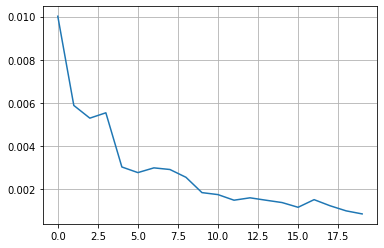

In [ ]:
plt.plot(pd.DataFrame(model_fit.history)) #모델 피팅 결과 시각화
plt.grid(True)
plt.show()

In [ ]:
Y_train_pred = model.predict(X_train) #예측 데이터 생성
Y_test_pred = model.predict(X_test)

##3.만든 모델 성능 평가

In [ ]:
#딥러닝에 딱히 평가하는 함수가 없어서 만들어주기
#이번 댐 성능평가는 MSE사용한다고 함.
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual

In [ ]:
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

35/35 [==============================] - 1s 9ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,334.801214,243676.066857,33.103663
Test,441.021102,922128.714463,51.885299


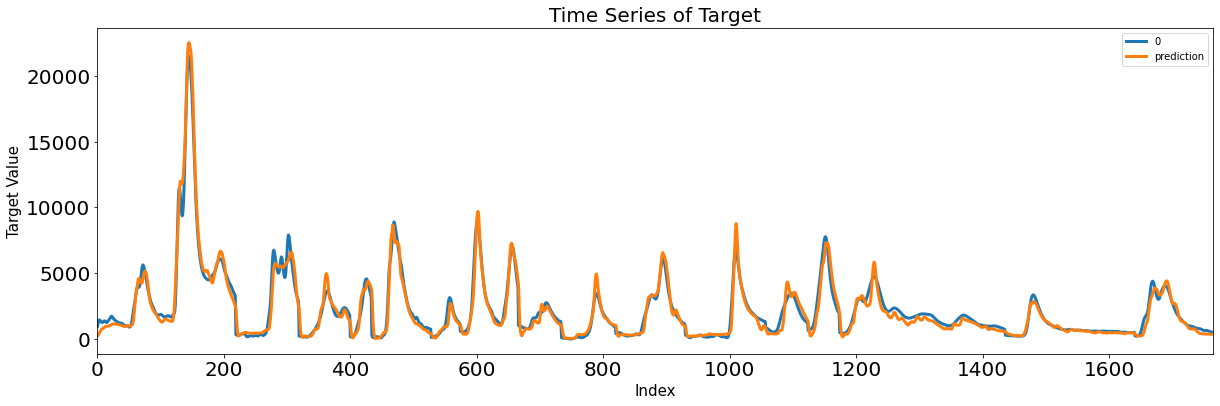

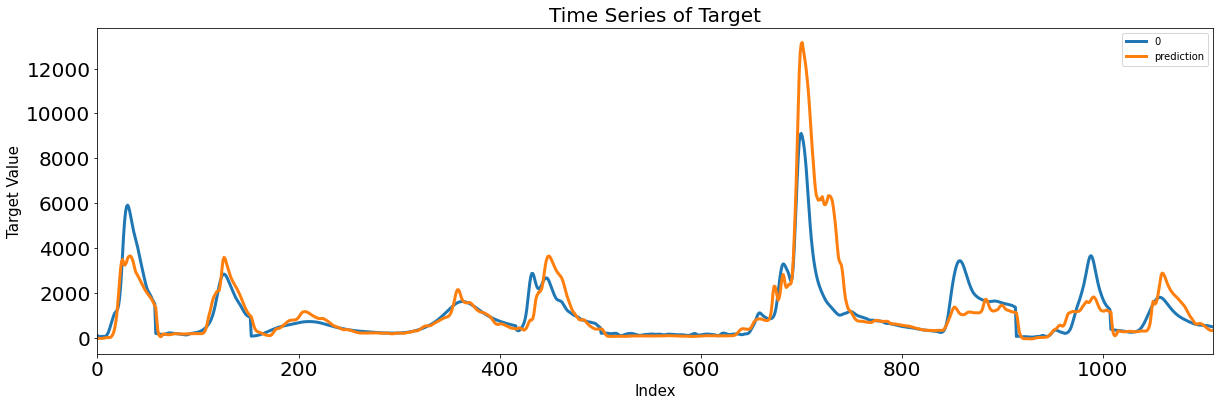

In [ ]:
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_train != []:
    Y_train = scaler_Y_train.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_train.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_train.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_train.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

##4.모델 사용하기

In [ ]:
X_train.shape

(1766, 7, 42)

In [ ]:
dam_df_raw

,case_num,datetime,inflow,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
0,1,2006-07-10 08:00:00,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610
1,1,2006-07-10 09:00:00,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600
2,1,2006-07-10 10:00:00,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590
3,1,2006-07-10 11:00:00,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585
4,1,2006-07-10 12:00:00,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26,2018-07-07 17:00:00,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950
3047,26,2018-07-07 18:00:00,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970
3048,26,2018-07-07 19:00:00,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980
3049,26,2018-07-07 20:00:00,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990


In [ ]:
dam_test_df = dam_df_raw[dam_df_raw['case_num'] >= 26]
dam_test_df

,case_num,datetime,inflow,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
2891,26,2018-07-01 06:00:00,NaN,14.2576,32,0,0,0,1.93,120.49375,10.9657,32,0,0,0,1.93,120.466667,10.9657,32,0,0,0,1.93,120.466667,7.9442,32,0,1,0,1.93,120.535714,1.1150,32,0,1,0,1.93,120.528,0.8413,32,0,1,0,1.93,120.515
2892,26,2018-07-01 07:00:00,NaN,10.9657,20,1,0,0,1.93,120.48750,7.9442,20,1,0,0,1.93,120.466667,7.9442,20,1,0,0,1.93,120.466667,7.8916,21,1,14,8,1.93,120.532143,5.0550,21,1,14,8,1.93,120.524,4.7653,21,1,14,8,1.93,120.510
2893,26,2018-07-01 08:00:00,NaN,7.9442,11,5,0,0,1.92,120.48125,7.8916,12,5,0,0,1.92,120.466667,7.8916,12,5,1,0,1.92,120.466667,13.3484,21,5,19,24,1.92,120.528571,13.3001,21,5,19,24,1.92,120.520,12.9398,21,5,19,24,1.92,120.505
2894,26,2018-07-01 09:00:00,NaN,7.8916,3,11,0,0,1.92,120.47500,13.3484,13,11,1,0,1.92,120.466667,13.3484,13,11,14,8,1.92,120.466667,20.0760,18,11,22,33,1.92,120.525000,20.0760,18,11,22,33,1.92,120.516,19.6616,18,11,22,33,1.92,120.500
2895,26,2018-07-01 10:00:00,NaN,13.3484,4,25,1,8,1.92,120.47500,20.0760,18,25,14,8,1.92,120.466667,20.0760,18,25,19,24,1.92,120.475000,27.0355,20,25,23,36,1.92,120.521429,26.9742,20,25,23,36,1.92,120.512,26.6211,20,25,23,36,1.92,120.495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26,2018-07-07 17:00:00,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950
3047,26,2018-07-07 18:00:00,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970
3048,26,2018-07-07 19:00:00,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980
3049,26,2018-07-07 20:00:00,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990


In [ ]:
X_hat = dam_test_df.iloc[:,3:]
X_hat

,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
2891,14.2576,32,0,0,0,1.93,120.49375,10.9657,32,0,0,0,1.93,120.466667,10.9657,32,0,0,0,1.93,120.466667,7.9442,32,0,1,0,1.93,120.535714,1.1150,32,0,1,0,1.93,120.528,0.8413,32,0,1,0,1.93,120.515
2892,10.9657,20,1,0,0,1.93,120.48750,7.9442,20,1,0,0,1.93,120.466667,7.9442,20,1,0,0,1.93,120.466667,7.8916,21,1,14,8,1.93,120.532143,5.0550,21,1,14,8,1.93,120.524,4.7653,21,1,14,8,1.93,120.510
2893,7.9442,11,5,0,0,1.92,120.48125,7.8916,12,5,0,0,1.92,120.466667,7.8916,12,5,1,0,1.92,120.466667,13.3484,21,5,19,24,1.92,120.528571,13.3001,21,5,19,24,1.92,120.520,12.9398,21,5,19,24,1.92,120.505
2894,7.8916,3,11,0,0,1.92,120.47500,13.3484,13,11,1,0,1.92,120.466667,13.3484,13,11,14,8,1.92,120.466667,20.0760,18,11,22,33,1.92,120.525000,20.0760,18,11,22,33,1.92,120.516,19.6616,18,11,22,33,1.92,120.500
2895,13.3484,4,25,1,8,1.92,120.47500,20.0760,18,25,14,8,1.92,120.466667,20.0760,18,25,19,24,1.92,120.475000,27.0355,20,25,23,36,1.92,120.521429,26.9742,20,25,23,36,1.92,120.512,26.6211,20,25,23,36,1.92,120.495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950
3047,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970
3048,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980
3049,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990


In [ ]:
X_hat_scaled = scaler_X_train.transform(X_hat)

In [ ]:
X_hat = []
for index in range(len(X_hat_scaled) - sequence):
  X_hat.append(np.array(X_hat_scaled[index:index + sequence])) 
X_hat = np.array(X_hat)

In [ ]:
X_hat.shape

(153, 7, 42)

In [ ]:
Y_hat = model.predict(X_hat)

In [ ]:
Y_hat = scaler_Y_train.inverse_transform(Y_hat)
Y_hat

array([[ 249.46529],
       [ 332.64853],
       [ 390.15247],
       [ 410.7856 ],
       [ 442.34845],
       [ 517.519  ],
       [ 625.1146 ],
       [ 740.71985],
       [ 829.3547 ],
       [ 876.9216 ],
       [ 885.3681 ],
       [ 883.6043 ],
       [ 886.89996],
       [ 897.6194 ],
       [ 932.04047],
       [1000.67737],
       [1109.8285 ],
       [1228.2618 ],
       [1346.6661 ],
       [1462.9188 ],
       [1585.2675 ],
       [1752.1151 ],
       [1868.874  ],
       [1909.924  ],
       [1908.636  ],
       [1928.9458 ],
       [1949.3625 ],
       [1970.341  ],
       [1989.6362 ],
       [2024.6093 ],
       [2066.1582 ],
       [2093.3271 ],
       [2088.324  ],
       [2049.7134 ],
       [1986.3801 ],
       [1918.9023 ],
       [1846.9973 ],
       [1768.4253 ],
       [1687.4615 ],
       [1615.0782 ],
       [1547.3994 ],
       [1481.693  ],
       [1431.0541 ],
       [1389.3284 ],
       [1360.4893 ],
       [1330.9932 ],
       [1300.1478 ],
       [1261.

##5.파라미터 최적화

In [ ]:
X_train_scaled

array([[0.01948843, 0.02545455, 0.01907357, ..., 0.03065134, 0.04959786,
        0.10931937],
       [0.01918392, 0.02545455, 0.02179837, ..., 0.03831418, 0.04892761,
        0.10890052],
       [0.01948843, 0.02545455, 0.02452316, ..., 0.04214559, 0.04892761,
        0.10848168],
       ...,
       [0.02201553, 0.        , 0.        , ..., 0.04980843, 0.08914209,
        0.79706806],
       [0.02135566, 0.        , 0.        , ..., 0.04980843, 0.08780161,
        0.79581152],
       [0.02119062, 0.        , 0.        , ..., 0.04980843, 0.08646113,
        0.79434555]])

In [ ]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
Score = dict()
seqsize_list = [i for i in range(1, 20, 1)]
for i in tqdm(seqsize_list):
    sequence = i

    ## X / Y 분리
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    # 형태확인
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # 모델생성
    model2 = Sequential()
    model2.add(LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model2.add(Dropout(dropout_ratio))
    model2.add(LSTM(256, return_sequences=True, activation='relu'))
    model2.add(Dropout(dropout_ratio))
    model2.add(LSTM(128, return_sequences=True, activation='relu'))
    model2.add(Dropout(dropout_ratio))
    model2.add(LSTM(64, return_sequences=False, activation='relu'))
    model2.add(Dropout(dropout_ratio))
    model2.add(Dense(1))
    model2.compile(optimizer='adam', loss = 'mean_squared_error')
    model2_fit = model2.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=1)
    # 예측
    Y_train_pred = model2.predict(X_train)
    Y_test_pred = model2.predict(X_test)

    result = model2.evaluate(X_test, Y_test_pred)
    if scaler_Y_train != []:
        Y_train = scaler_Y_train.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_train.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_train.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_train.inverse_transform(Y_test_pred)
    Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
    
    Score[str(sequence)] = Score_LSTM

  0%|          | 0/19 [00:00<?, ?it/s]

X_train: (1772, 1, 42) Y_train: (1772, 1)
X_test: (1117, 1, 42) Y_test: (1117, 1)
Epoch 1/20
71/71 [==============================] - 6s 22ms/step - loss: 0.0115
Epoch 2/20
71/71 [==============================] - 2s 23ms/step - loss: 0.0046
Epoch 3/20
71/71 [==============================] - 1s 21ms/step - loss: 0.0043
Epoch 4/20
71/71 [==============================] - 2s 22ms/step - loss: 0.0031
Epoch 5/20
71/71 [==============================] - 2s 22ms/step - loss: 0.0026
Epoch 6/20
71/71 [==============================] - 2s 22ms/step - loss: 0.0039
Epoch 7/20
71/71 [==============================] - 2s 21ms/step - loss: 0.0026
Epoch 8/20
71/71 [==============================] - 1s 21ms/step - loss: 0.0020
Epoch 9/20
71/71 [==============================] - 1s 21ms/step - loss: 0.0018
Epoch 10/20
71/71 [==============================] - 2s 22ms/step - loss: 0.0020
Epoch 11/20
71/71 [==============================] - 2s 22ms/step - loss: 0.0021
Epoch 12/20
71/71 [=================

  5%|▌         | 1/19 [00:37<11:13, 37.44s/it]

X_train: (1771, 2, 42) Y_train: (1771, 1)
X_test: (1116, 2, 42) Y_test: (1116, 1)
Epoch 1/20
71/71 [==============================] - 7s 33ms/step - loss: 0.0112
Epoch 2/20
71/71 [==============================] - 2s 32ms/step - loss: 0.0054
Epoch 3/20
71/71 [==============================] - 2s 34ms/step - loss: 0.0039
Epoch 4/20
71/71 [==============================] - 2s 32ms/step - loss: 0.0026
Epoch 5/20
71/71 [==============================] - 2s 32ms/step - loss: 0.0037
Epoch 6/20
71/71 [==============================] - 2s 31ms/step - loss: 0.0034
Epoch 7/20
71/71 [==============================] - 2s 31ms/step - loss: 0.0023
Epoch 8/20
71/71 [==============================] - 2s 32ms/step - loss: 0.0025
Epoch 9/20
71/71 [==============================] - 2s 33ms/step - loss: 0.0020
Epoch 10/20
71/71 [==============================] - 2s 32ms/step - loss: 0.0019
Epoch 11/20
71/71 [==============================] - 2s 32ms/step - loss: 0.0018
Epoch 12/20
71/71 [=================

 11%|█         | 2/19 [02:05<19:05, 67.35s/it]

X_train: (1770, 3, 42) Y_train: (1770, 1)
X_test: (1115, 3, 42) Y_test: (1115, 1)
Epoch 1/20
71/71 [==============================] - 7s 40ms/step - loss: 0.0078
Epoch 2/20
71/71 [==============================] - 3s 42ms/step - loss: 0.0051
Epoch 3/20
71/71 [==============================] - 3s 41ms/step - loss: 0.0036
Epoch 4/20
71/71 [==============================] - 3s 40ms/step - loss: 0.0037
Epoch 5/20
71/71 [==============================] - 3s 40ms/step - loss: 0.0038
Epoch 6/20
71/71 [==============================] - 3s 40ms/step - loss: 0.0054
Epoch 7/20
71/71 [==============================] - 3s 40ms/step - loss: 0.0040
Epoch 8/20
71/71 [==============================] - 3s 40ms/step - loss: 0.0034
Epoch 9/20
71/71 [==============================] - 3s 40ms/step - loss: 0.0030
Epoch 10/20
71/71 [==============================] - 3s 40ms/step - loss: 0.0024
Epoch 11/20
71/71 [==============================] - 3s 40ms/step - loss: 0.0026
Epoch 12/20
71/71 [=================

 16%|█▌        | 3/19 [03:34<20:36, 77.25s/it]

X_train: (1769, 4, 42) Y_train: (1769, 1)
X_test: (1114, 4, 42) Y_test: (1114, 1)
Epoch 1/20
71/71 [==============================] - 8s 52ms/step - loss: 0.0087
Epoch 2/20
71/71 [==============================] - 4s 52ms/step - loss: 0.0045
Epoch 3/20
71/71 [==============================] - 4s 53ms/step - loss: 0.0039
Epoch 4/20
71/71 [==============================] - 4s 53ms/step - loss: 0.0032
Epoch 5/20
71/71 [==============================] - 3s 49ms/step - loss: 0.0032
Epoch 6/20
71/71 [==============================] - 4s 51ms/step - loss: 0.0029
Epoch 7/20
71/71 [==============================] - 4s 51ms/step - loss: 0.0030
Epoch 8/20
71/71 [==============================] - 4s 50ms/step - loss: 0.0036
Epoch 9/20
71/71 [==============================] - 4s 50ms/step - loss: 0.0029
Epoch 10/20
71/71 [==============================] - 4s 52ms/step - loss: 0.0022
Epoch 11/20
71/71 [==============================] - 4s 51ms/step - loss: 0.0015
Epoch 12/20
71/71 [=================

 21%|██        | 4/19 [05:03<20:29, 81.94s/it]

X_train: (1768, 5, 42) Y_train: (1768, 1)
X_test: (1113, 5, 42) Y_test: (1113, 1)
Epoch 1/20
71/71 [==============================] - 9s 62ms/step - loss: 0.0074
Epoch 2/20
71/71 [==============================] - 4s 61ms/step - loss: 0.0052
Epoch 3/20
71/71 [==============================] - 4s 62ms/step - loss: 0.0042
Epoch 4/20
71/71 [==============================] - 5s 65ms/step - loss: 0.0035
Epoch 5/20
71/71 [==============================] - 4s 63ms/step - loss: 0.0027
Epoch 6/20
71/71 [==============================] - 4s 63ms/step - loss: 0.0058
Epoch 7/20
71/71 [==============================] - 4s 63ms/step - loss: 0.0043
Epoch 8/20
71/71 [==============================] - 4s 62ms/step - loss: 0.0037
Epoch 9/20
71/71 [==============================] - 4s 62ms/step - loss: 0.0026
Epoch 10/20
71/71 [==============================] - 4s 61ms/step - loss: 0.0044
Epoch 11/20
71/71 [==============================] - 4s 62ms/step - loss: 0.0020
Epoch 12/20
71/71 [=================

 26%|██▋       | 5/19 [07:32<24:44, 106.04s/it]

X_train: (1767, 6, 42) Y_train: (1767, 1)
X_test: (1112, 6, 42) Y_test: (1112, 1)
Epoch 1/20
71/71 [==============================] - 9s 70ms/step - loss: 0.0083
Epoch 2/20
71/71 [==============================] - 5s 71ms/step - loss: 0.0083
Epoch 3/20
71/71 [==============================] - 5s 71ms/step - loss: 0.0056
Epoch 4/20
71/71 [==============================] - 5s 72ms/step - loss: 0.0042
Epoch 5/20
71/71 [==============================] - 5s 71ms/step - loss: 0.0038
Epoch 6/20
71/71 [==============================] - 5s 72ms/step - loss: 0.0036
Epoch 7/20
71/71 [==============================] - 5s 72ms/step - loss: 0.0039
Epoch 8/20
71/71 [==============================] - 5s 71ms/step - loss: 0.0022
Epoch 9/20
71/71 [==============================] - 5s 72ms/step - loss: 0.0025
Epoch 10/20
71/71 [==============================] - 5s 72ms/step - loss: 0.0018
Epoch 11/20
71/71 [==============================] - 5s 72ms/step - loss: 0.0015
Epoch 12/20
71/71 [=================

 32%|███▏      | 6/19 [09:22<23:13, 107.18s/it]

X_train: (1766, 7, 42) Y_train: (1766, 1)
X_test: (1111, 7, 42) Y_test: (1111, 1)
Epoch 1/20
71/71 [==============================] - 10s 81ms/step - loss: 0.0081
Epoch 2/20
71/71 [==============================] - 6s 82ms/step - loss: 0.0089
Epoch 3/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0049
Epoch 4/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0037
Epoch 5/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0106
Epoch 6/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0062
Epoch 7/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0047
Epoch 8/20
71/71 [==============================] - 6s 81ms/step - loss: 0.0036
Epoch 9/20
71/71 [==============================] - 6s 79ms/step - loss: 0.0027
Epoch 10/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0027
Epoch 11/20
71/71 [==============================] - 6s 80ms/step - loss: 0.0020
Epoch 12/20
71/71 [================

 37%|███▋      | 7/19 [11:23<22:21, 111.78s/it]

X_train: (1765, 8, 42) Y_train: (1765, 1)
X_test: (1110, 8, 42) Y_test: (1110, 1)
Epoch 1/20
71/71 [==============================] - 11s 89ms/step - loss: 0.0090
Epoch 2/20
71/71 [==============================] - 6s 88ms/step - loss: 0.0083
Epoch 3/20
71/71 [==============================] - 6s 89ms/step - loss: 0.0056
Epoch 4/20
71/71 [==============================] - 6s 89ms/step - loss: 0.0048
Epoch 5/20
71/71 [==============================] - 6s 89ms/step - loss: 0.0048
Epoch 6/20
71/71 [==============================] - 6s 88ms/step - loss: 0.0030
Epoch 7/20
71/71 [==============================] - 6s 88ms/step - loss: 0.0025
Epoch 8/20
71/71 [==============================] - 6s 88ms/step - loss: 0.0017
Epoch 9/20
71/71 [==============================] - 6s 91ms/step - loss: 0.0026
Epoch 10/20
71/71 [==============================] - 6s 89ms/step - loss: 0.0018
Epoch 11/20
71/71 [==============================] - 6s 89ms/step - loss: 0.0014
Epoch 12/20
71/71 [================

 42%|████▏     | 8/19 [13:36<21:45, 118.72s/it]

X_train: (1764, 9, 42) Y_train: (1764, 1)
X_test: (1109, 9, 42) Y_test: (1109, 1)
Epoch 1/20
71/71 [==============================] - 11s 99ms/step - loss: 0.0083
Epoch 2/20
71/71 [==============================] - 7s 96ms/step - loss: 0.0079
Epoch 3/20
71/71 [==============================] - 7s 98ms/step - loss: 0.0047
Epoch 4/20
71/71 [==============================] - 7s 99ms/step - loss: 0.0041
Epoch 5/20
71/71 [==============================] - 7s 99ms/step - loss: 0.0037
Epoch 6/20
71/71 [==============================] - 7s 97ms/step - loss: 0.0035
Epoch 7/20
71/71 [==============================] - 7s 98ms/step - loss: 0.0022
Epoch 8/20
71/71 [==============================] - 7s 100ms/step - loss: 0.0018
Epoch 9/20
71/71 [==============================] - 7s 99ms/step - loss: 0.0014
Epoch 10/20
71/71 [==============================] - 7s 98ms/step - loss: 0.0015
Epoch 11/20
71/71 [==============================] - 7s 99ms/step - loss: 0.0013
Epoch 12/20
71/71 [===============

 47%|████▋     | 9/19 [16:04<21:16, 127.61s/it]

X_train: (1763, 10, 42) Y_train: (1763, 1)
X_test: (1108, 10, 42) Y_test: (1108, 1)
Epoch 1/20
71/71 [==============================] - 12s 110ms/step - loss: 0.0084
Epoch 2/20
71/71 [==============================] - 8s 110ms/step - loss: 0.0075
Epoch 3/20
71/71 [==============================] - 8s 109ms/step - loss: 0.0080
Epoch 4/20
71/71 [==============================] - 8s 109ms/step - loss: 0.0054
Epoch 5/20
71/71 [==============================] - 8s 108ms/step - loss: 0.0038
Epoch 6/20
71/71 [==============================] - 8s 109ms/step - loss: 0.0038
Epoch 7/20
71/71 [==============================] - 8s 108ms/step - loss: 0.0025
Epoch 8/20
71/71 [==============================] - 8s 110ms/step - loss: 0.0025
Epoch 9/20
71/71 [==============================] - 8s 107ms/step - loss: 0.0040
Epoch 10/20
71/71 [==============================] - 8s 109ms/step - loss: 0.0024
Epoch 11/20
71/71 [==============================] - 8s 109ms/step - loss: 0.0020
Epoch 12/20
71/71 [===

 53%|█████▎    | 10/19 [19:34<22:57, 153.03s/it]

X_train: (1762, 11, 42) Y_train: (1762, 1)
X_test: (1107, 11, 42) Y_test: (1107, 1)
Epoch 1/20
71/71 [==============================] - 13s 118ms/step - loss: 0.0087
Epoch 2/20
71/71 [==============================] - 9s 121ms/step - loss: 0.0081
Epoch 3/20
71/71 [==============================] - 8s 117ms/step - loss: 0.0072
Epoch 4/20
71/71 [==============================] - 8s 118ms/step - loss: 0.0057
Epoch 5/20
71/71 [==============================] - 8s 116ms/step - loss: 0.0078
Epoch 6/20
71/71 [==============================] - 8s 119ms/step - loss: 0.0056
Epoch 7/20
71/71 [==============================] - 8s 119ms/step - loss: 0.0037
Epoch 8/20
71/71 [==============================] - 8s 117ms/step - loss: 0.0021
Epoch 9/20
71/71 [==============================] - 8s 119ms/step - loss: 0.0031
Epoch 10/20
71/71 [==============================] - 9s 121ms/step - loss: 0.0021
Epoch 11/20
71/71 [==============================] - 9s 120ms/step - loss: 0.0015
Epoch 12/20
71/71 [===

 58%|█████▊    | 11/19 [23:03<22:42, 170.34s/it]

X_train: (1761, 12, 42) Y_train: (1761, 1)
X_test: (1106, 12, 42) Y_test: (1106, 1)
Epoch 1/20
71/71 [==============================] - 13s 127ms/step - loss: 0.0080
Epoch 2/20
71/71 [==============================] - 9s 127ms/step - loss: 0.0077
Epoch 3/20
71/71 [==============================] - 9s 125ms/step - loss: 0.0063
Epoch 4/20
71/71 [==============================] - 9s 131ms/step - loss: 0.0058
Epoch 5/20
71/71 [==============================] - 9s 129ms/step - loss: 0.0039
Epoch 6/20
71/71 [==============================] - 9s 130ms/step - loss: 0.0036
Epoch 7/20
71/71 [==============================] - 9s 131ms/step - loss: 0.0023
Epoch 8/20
71/71 [==============================] - 9s 131ms/step - loss: 0.0018
Epoch 9/20
71/71 [==============================] - 9s 129ms/step - loss: 0.0015
Epoch 10/20
71/71 [==============================] - 9s 129ms/step - loss: 0.0021
Epoch 11/20
71/71 [==============================] - 9s 126ms/step - loss: 0.0022
Epoch 12/20
71/71 [===

 63%|██████▎   | 12/19 [26:33<21:16, 182.33s/it]

X_train: (1760, 13, 42) Y_train: (1760, 1)
X_test: (1105, 13, 42) Y_test: (1105, 1)
Epoch 1/20
71/71 [==============================] - 14s 136ms/step - loss: 0.0106
Epoch 2/20
71/71 [==============================] - 10s 138ms/step - loss: 0.0077
Epoch 3/20
71/71 [==============================] - 10s 138ms/step - loss: 0.0067
Epoch 4/20
71/71 [==============================] - 10s 137ms/step - loss: 0.0089
Epoch 5/20
71/71 [==============================] - 10s 137ms/step - loss: 0.0069
Epoch 6/20
71/71 [==============================] - 10s 138ms/step - loss: 0.0057
Epoch 7/20
71/71 [==============================] - 10s 137ms/step - loss: 0.0038
Epoch 8/20
71/71 [==============================] - 10s 137ms/step - loss: 0.0027
Epoch 9/20
71/71 [==============================] - 10s 136ms/step - loss: 0.0027
Epoch 10/20
71/71 [==============================] - 10s 135ms/step - loss: 0.0020
Epoch 11/20
71/71 [==============================] - 10s 136ms/step - loss: 0.0020
Epoch 12/20


 68%|██████▊   | 13/19 [29:55<18:50, 188.47s/it]

X_train: (1759, 14, 42) Y_train: (1759, 1)
X_test: (1104, 14, 42) Y_test: (1104, 1)
Epoch 1/20
71/71 [==============================] - 15s 147ms/step - loss: 0.0104
Epoch 2/20
71/71 [==============================] - 11s 149ms/step - loss: 0.0077
Epoch 3/20
71/71 [==============================] - 10s 145ms/step - loss: 0.0068
Epoch 4/20
71/71 [==============================] - 10s 146ms/step - loss: 0.0092
Epoch 5/20
71/71 [==============================] - 10s 147ms/step - loss: 0.0043
Epoch 6/20
71/71 [==============================] - 10s 146ms/step - loss: 0.0036
Epoch 7/20
71/71 [==============================] - 11s 149ms/step - loss: 0.0021
Epoch 8/20
71/71 [==============================] - 11s 148ms/step - loss: 0.0026
Epoch 9/20
71/71 [==============================] - 10s 147ms/step - loss: 0.0018
Epoch 10/20
71/71 [==============================] - 11s 148ms/step - loss: 0.0013
Epoch 11/20
71/71 [==============================] - 10s 146ms/step - loss: 0.0023
Epoch 12/20


 74%|███████▎  | 14/19 [34:25<17:45, 213.09s/it]

X_train: (1758, 15, 42) Y_train: (1758, 1)
X_test: (1103, 15, 42) Y_test: (1103, 1)
Epoch 1/20
71/71 [==============================] - 15s 154ms/step - loss: 0.0092
Epoch 2/20
71/71 [==============================] - 11s 153ms/step - loss: 0.0081
Epoch 3/20
71/71 [==============================] - 11s 153ms/step - loss: 0.0074
Epoch 4/20
71/71 [==============================] - 11s 153ms/step - loss: 0.0059
Epoch 5/20
71/71 [==============================] - 11s 154ms/step - loss: 0.0030
Epoch 6/20
71/71 [==============================] - 11s 153ms/step - loss: 0.0019
Epoch 7/20
71/71 [==============================] - 11s 153ms/step - loss: 0.0018
Epoch 8/20
71/71 [==============================] - 11s 151ms/step - loss: 0.0028
Epoch 9/20
71/71 [==============================] - 11s 154ms/step - loss: 0.0019
Epoch 10/20
71/71 [==============================] - 11s 155ms/step - loss: 0.0017
Epoch 11/20
71/71 [==============================] - 11s 153ms/step - loss: 0.0016
Epoch 12/20


 79%|███████▉  | 15/19 [38:55<15:20, 230.05s/it]

X_train: (1757, 16, 42) Y_train: (1757, 1)
X_test: (1102, 16, 42) Y_test: (1102, 1)
Epoch 1/20
71/71 [==============================] - 17s 164ms/step - loss: 0.0102
Epoch 2/20
71/71 [==============================] - 12s 165ms/step - loss: 0.0084
Epoch 3/20
71/71 [==============================] - 12s 165ms/step - loss: 0.0066
Epoch 4/20
71/71 [==============================] - 12s 162ms/step - loss: 0.0049
Epoch 5/20
71/71 [==============================] - 12s 164ms/step - loss: 0.0085
Epoch 6/20
71/71 [==============================] - 12s 167ms/step - loss: 0.0056
Epoch 7/20
71/71 [==============================] - 12s 165ms/step - loss: 0.0035
Epoch 8/20
71/71 [==============================] - 12s 167ms/step - loss: 0.0025
Epoch 9/20
71/71 [==============================] - 12s 166ms/step - loss: 0.0021
Epoch 10/20
71/71 [==============================] - 12s 165ms/step - loss: 0.0017
Epoch 11/20
71/71 [==============================] - 12s 165ms/step - loss: 0.0014
Epoch 12/20


 84%|████████▍ | 16/19 [43:25<12:06, 242.19s/it]

X_train: (1756, 17, 42) Y_train: (1756, 1)
X_test: (1101, 17, 42) Y_test: (1101, 1)
Epoch 1/20
71/71 [==============================] - 17s 177ms/step - loss: 0.0113
Epoch 2/20
71/71 [==============================] - 12s 176ms/step - loss: 0.0123
Epoch 3/20
71/71 [==============================] - 12s 174ms/step - loss: 0.0077
Epoch 4/20
71/71 [==============================] - 12s 174ms/step - loss: 0.0053
Epoch 5/20
71/71 [==============================] - 13s 176ms/step - loss: 0.0047
Epoch 6/20
71/71 [==============================] - 12s 174ms/step - loss: 0.0046
Epoch 7/20
71/71 [==============================] - 12s 175ms/step - loss: 0.0037
Epoch 8/20
71/71 [==============================] - 12s 175ms/step - loss: 0.0021
Epoch 9/20
71/71 [==============================] - 12s 174ms/step - loss: 0.0026
Epoch 10/20
71/71 [==============================] - 12s 175ms/step - loss: 0.0019
Epoch 11/20
71/71 [==============================] - 12s 176ms/step - loss: 0.0016
Epoch 12/20


 89%|████████▉ | 17/19 [47:55<08:21, 250.50s/it]

X_train: (1755, 18, 42) Y_train: (1755, 1)
X_test: (1100, 18, 42) Y_test: (1100, 1)
Epoch 1/20
71/71 [==============================] - 18s 184ms/step - loss: 0.0098
Epoch 2/20
71/71 [==============================] - 13s 182ms/step - loss: 0.0068
Epoch 3/20
71/71 [==============================] - 13s 181ms/step - loss: 0.0068
Epoch 4/20
71/71 [==============================] - 13s 180ms/step - loss: 0.0035
Epoch 5/20
71/71 [==============================] - 13s 181ms/step - loss: 0.0027
Epoch 6/20
71/71 [==============================] - 13s 184ms/step - loss: 0.0023
Epoch 7/20
71/71 [==============================] - 13s 189ms/step - loss: 0.0016
Epoch 8/20
71/71 [==============================] - 13s 186ms/step - loss: 0.0016
Epoch 9/20
71/71 [==============================] - 13s 186ms/step - loss: 0.0020
Epoch 10/20
71/71 [==============================] - 13s 183ms/step - loss: 0.0015
Epoch 11/20
71/71 [==============================] - 13s 186ms/step - loss: 0.0013
Epoch 12/20


 95%|█████████▍| 18/19 [53:26<04:34, 274.55s/it]

X_train: (1754, 19, 42) Y_train: (1754, 1)
X_test: (1099, 19, 42) Y_test: (1099, 1)
Epoch 1/20
71/71 [==============================] - 18s 192ms/step - loss: 0.0097
Epoch 2/20
71/71 [==============================] - 14s 193ms/step - loss: 0.0082
Epoch 3/20
71/71 [==============================] - 14s 191ms/step - loss: 0.0537
Epoch 4/20
71/71 [==============================] - 14s 192ms/step - loss: 0.0071
Epoch 5/20
71/71 [==============================] - 14s 193ms/step - loss: 0.0058
Epoch 6/20
71/71 [==============================] - 14s 193ms/step - loss: 0.0033
Epoch 7/20
71/71 [==============================] - 14s 193ms/step - loss: 0.0031
Epoch 8/20
71/71 [==============================] - 14s 192ms/step - loss: 0.0037
Epoch 9/20
71/71 [==============================] - 14s 195ms/step - loss: 0.0023
Epoch 10/20
71/71 [==============================] - 14s 193ms/step - loss: 0.0025
Epoch 11/20
71/71 [==============================] - 14s 194ms/step - loss: 0.0024
Epoch 12/20


100%|██████████| 19/19 [58:56<00:00, 186.11s/it]


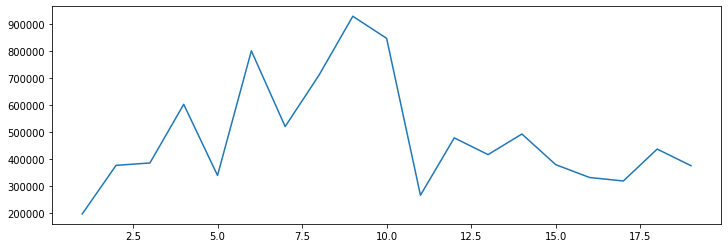

In [ ]:
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

In [ ]:
Score = dict()
batchsize_list = [i for i in range(5, 50, 5)]
for i in tqdm(batchsize_list):
    batch_size = i

    ## X / Y 분리
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    # 형태확인
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # 모델생성
    model3 = Sequential()
    model3.add(LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model3.add(Dropout(dropout_ratio))
    model3.add(LSTM(256, return_sequences=True, activation='relu'))
    model3.add(Dropout(dropout_ratio))
    model3.add(LSTM(128, return_sequences=True, activation='relu'))
    model3.add(Dropout(dropout_ratio))
    model3.add(LSTM(64, return_sequences=False, activation='relu'))
    model3.add(Dropout(dropout_ratio))
    model3.add(Dense(1))
    model3.compile(optimizer='adam', loss = 'mean_squared_error')
    model3_fit = model3.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=1)
    # 예측
    Y_train_pred = model3.predict(X_train)
    Y_test_pred = model3.predict(X_test)

    result = model3.evaluate(X_test, Y_test_pred)
    if scaler_Y_train != []:
        Y_train = scaler_Y_train.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_train.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_train.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_train.inverse_transform(Y_test_pred)
    Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
    
    Score[str(batch_size)] = Score_LSTM

  0%|          | 0/9 [00:00<?, ?it/s]

X_train: (1754, 19, 42) Y_train: (1754, 1)
X_test: (1099, 19, 42) Y_test: (1099, 1)
Epoch 1/20
351/351 [==============================] - 71s 189ms/step - loss: 0.0099
Epoch 2/20
351/351 [==============================] - 67s 191ms/step - loss: 0.0133
Epoch 3/20
351/351 [==============================] - 67s 190ms/step - loss: 0.0052
Epoch 4/20
351/351 [==============================] - 66s 189ms/step - loss: 0.0928
Epoch 5/20
351/351 [==============================] - 67s 190ms/step - loss: 0.0087
Epoch 6/20
351/351 [==============================] - 67s 191ms/step - loss: 0.0604
Epoch 7/20
351/351 [==============================] - 67s 191ms/step - loss: 0.0125
Epoch 8/20
351/351 [==============================] - 67s 192ms/step - loss: 0.0080
Epoch 9/20
351/351 [==============================] - 67s 192ms/step - loss: 0.0055
Epoch 10/20
351/351 [==============================] - 67s 191ms/step - loss: 0.0043
Epoch 11/20
351/351 [==============================] - 67s 192ms/step - los

 11%|█         | 1/9 [23:30<3:08:04, 1410.52s/it]

X_train: (1754, 19, 42) Y_train: (1754, 1)
X_test: (1099, 19, 42) Y_test: (1099, 1)
Epoch 1/20
176/176 [==============================] - 38s 193ms/step - loss: 0.0096
Epoch 2/20
176/176 [==============================] - 34s 192ms/step - loss: 0.0071
Epoch 3/20
176/176 [==============================] - 34s 192ms/step - loss: 0.0069
Epoch 4/20
176/176 [==============================] - 34s 194ms/step - loss: 0.0032
Epoch 5/20
176/176 [==============================] - 34s 194ms/step - loss: 0.0041
Epoch 6/20
176/176 [==============================] - 34s 195ms/step - loss: 0.0027
Epoch 7/20
176/176 [==============================] - 34s 192ms/step - loss: 0.0021
Epoch 8/20
176/176 [==============================] - 34s 193ms/step - loss: 0.0020
Epoch 9/20
176/176 [==============================] - 34s 193ms/step - loss: 0.0015
Epoch 10/20
176/176 [==============================] - 34s 194ms/step - loss: 0.0018
Epoch 11/20
176/176 [==============================] - 34s 194ms/step - los

In [ ]:
   seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = batchsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

##6.결과 해석

sequence = 7, batch_size = 25 일때가 가장 좋은 성능을 보여준다는 것을 알 수 있다.

초기: sequence = 12, batch_size = 30

In [ ]:
import  